In [2]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Custom Dataset and LSTM model

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.input = torch.load(file_path + 'input.pt')
        self.label = torch.load(file_path + 'label.pt')

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self, idx):
        return self.input[idx], self.label[idx]


train_dir = '/content/drive/MyDrive/substorm_prediction/train/'
test_dir = '/content/drive/MyDrive/substorm_prediction/test/'

train_dataset = MyDataset(train_dir)
test_dataset = MyDataset(test_dir)

In [5]:
class MyModel(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, num_layers=1, dropout=0):
        super(MyModel, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = num_layers, 
                            dropout = dropout if num_layers > 1 else 0,
                            batch_first = True)
        
        self.linear = nn.Linear(hidden_dim * seq_len, 1)

        self.dropout = dropout

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        relu_out = nn.ReLU()(lstm_out)
        dropout_out = nn.Dropout(self.dropout)(relu_out)
        flatten_out = nn.Flatten()(dropout_out)
        linear_out = self.linear(flatten_out)
        return nn.Sigmoid()(linear_out)

In [6]:
input_dim = 9
seq_len = 600
hidden_dim = 5
num_layers = 2
dropout = 0.2

lstm_model = MyModel(input_dim, seq_len, hidden_dim, num_layers, dropout)

# take a look at the shape of the weights for each layer
for p in lstm_model.parameters():
    print(p.data.shape)

# our model has some # of parameters:
count = 0
for p in lstm_model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

torch.Size([20, 9])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([20, 5])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([1, 3000])
torch.Size([1])
total params: 3561


# Training

In [7]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

    # We could write our training procedure manually and directly index the `Dataset` objects,
    # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.BCELoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    test_accuracy_history = np.zeros([n_epochs, 1])
    test_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = torch.squeeze(model(data))

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        test_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in test_loader:
                output = torch.squeeze(model(data))
                test_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output >= 0.5 # Get the index of the max class score
                correct += pred.eq(target.bool()).sum().item()

        test_loss_history[epoch] = test_loss / len(test_loader.dataset)
        test_accuracy_history[epoch] = correct / len(test_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (test_loss_history[epoch], correct, len(test_loader.dataset),
              100. * test_accuracy_history[epoch]))
    
    return model, train_loss_history, test_loss_history, test_accuracy_history

In [22]:
trained_model, train_loss_history, test_loss_history, test_accuracy_history = run_training_loop(lstm_model, batch_size=4, n_epochs=10)

Train Epoch: 1  Average loss: 0.0802
Valid set: Average loss: 0.2064, Accuracy: 50/70 (71.4286)

Train Epoch: 2  Average loss: 0.0778
Valid set: Average loss: 0.1941, Accuracy: 51/70 (72.8571)

Train Epoch: 3  Average loss: 0.0749
Valid set: Average loss: 0.1826, Accuracy: 52/70 (74.2857)

Train Epoch: 4  Average loss: 0.0708
Valid set: Average loss: 0.2159, Accuracy: 51/70 (72.8571)

Train Epoch: 5  Average loss: 0.0683
Valid set: Average loss: 0.1980, Accuracy: 51/70 (72.8571)

Train Epoch: 6  Average loss: 0.0673
Valid set: Average loss: 0.2177, Accuracy: 51/70 (72.8571)

Train Epoch: 7  Average loss: 0.0613
Valid set: Average loss: 0.2049, Accuracy: 48/70 (68.5714)

Train Epoch: 8  Average loss: 0.0609
Valid set: Average loss: 0.2248, Accuracy: 51/70 (72.8571)

Train Epoch: 9  Average loss: 0.0584
Valid set: Average loss: 0.2606, Accuracy: 50/70 (71.4286)

Train Epoch: 10  Average loss: 0.0545
Valid set: Average loss: 0.2646, Accuracy: 48/70 (68.5714)



# Results

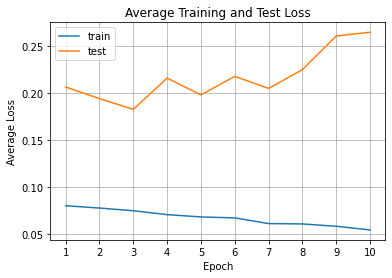

In [33]:
plt.plot(np.arange(1, 11), train_loss_history, label='train')
plt.plot(np.arange(1, 11), test_loss_history, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Training and Test Loss')
plt.xticks(np.arange(1, 11))
plt.grid()
plt.show()

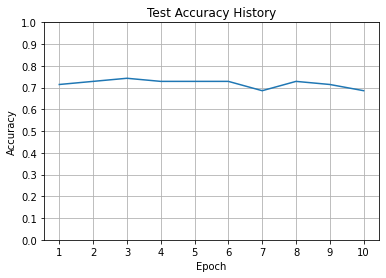

In [34]:
plt.plot(np.arange(1, 11), test_accuracy_history)
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy History')
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show()